Observed
-----
Talk about qdpi and how you build the alleles from sequencing data and also the truth dataset.

Make the low/medium/high vaf bins and the curves

Do it again with the ultra-low separated.

Talk about how these curves have a pattern and you can imagine, well, if we had higher coverage, wouldn't the proportion which are supported increase?

Move into beta binomial distribution (you can do just a bernolli trial, but that doesn't work for whatever reasons.

Then we can match the observed 'recall' to our model to show it largely holds up.

Detour: Can we update the expected VAF based on the observed coverage? And possibly weigh the recall by the probability. The second one is a little more interesting. Like, can we better approximate how good the recall is based on our modeling? Like, if we see that of the 100 sites with VAF of 0.1, the 100x coverage says 67% of them should be supported by ≥8. If the tool is only finding 40%, then we know that there is something off about the caller.

Just a simple score can work where we measure the observed / expected percents. if it's 1, it's doing fine, > better and < worse than what's possible. If we then put our min_reads at something like 5, but allow the tools to report as little as 1 read, we can then get an idea of the tools ability to handle super low coverage.


In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

full_data = pd.read_parquet("../allele_delta/data/hapmix.allele_delta.hifi.WashU.pq")
#measure = full_data[(full_data['observed_vaf'] != 0)
#           ].sample(5000, random_state=20)
measure = full_data

In [2]:
df = measure[measure['coverage'] != 0]

# All alternate alleles ≥5bp
j = df.set_index(['chrom', 'start', 'end'])
# Condition 1: all non-zero expected_len are > 5
cond1 = j[j['expected_len'] != 0]['expected_len'].abs().gt(5).groupby(['chrom', 'start', 'end']).all()
# Condition 2: at least one non-zero expected_len
cond2 = j['expected_len'].ne(0).groupby(['chrom', 'start', 'end']).any()
# Combine both conditions
keep = cond1 & cond2
# Subset data
df = j.loc[keep[keep].index].reset_index()
measure = df

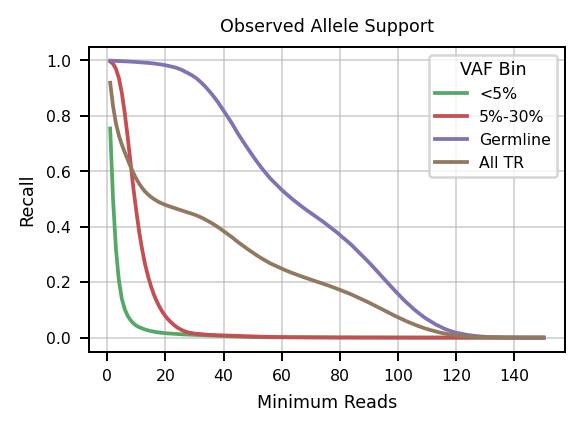

In [3]:
subset = measure['expected_len'].abs() >= 0
hyper_low = measure['expected_vaf'] < 0.05
low = measure['expected_vaf'].between(0.05, 0.30, inclusive='left')
germ = measure['expected_vaf'].between(0.30, 1)

def foo(x, min_reads, name):
    tp = (x['read_count'] >= min_reads).sum()
    total = len(x)
    fn = total - tp
    return [tp, fn, total, tp/total, min_reads, name]

rows = []
for name, df in [('All TR', subset), ('<5%', hyper_low), ('5%-30%', low), ('Germline', germ)]:
    view = measure[subset & df]
    for cov_x in range(1, 151):
        rows.append(foo(view, cov_x, name))
    
obs_dis = pd.DataFrame(rows, columns=['TP', 'FN', 'total', 'recall', "min reads", "VAF Bin"])

# Observed Allele Support CDF

palette = sb.color_palette('deep', n_colors=8) 

def scaled_fontsize(base_size, fig_width, reference_width=6.4, min_size=7):
    """
    Scales the base font size proportionally to figure width,
    but enforces a minimum font size.
    
    base_size: font size for reference_width (in inches)
    fig_width: actual figure width
    """
    scale = fig_width / reference_width
    return max(min_size, base_size * scale)


fig_width = 3.25
font_size = scaled_fontsize(base_size=12, fig_width=fig_width, min_size=7)

plt.rcParams.update({
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size * 0.9,
    "ytick.labelsize": font_size * 0.9,
    "legend.fontsize": font_size * 0.9,
})

fig, ax = plt.subplots(nrows=1, 
                       ncols=1, 
                       #figsize=(5 * len(files), 5), 
                       figsize=(3.25, 2.4), # For hifi.washu
                       squeeze=False,
                       sharex='row',
                       sharey='row',
                       dpi=180,
                      )

p = sb.lineplot(data=obs_dis, 
                x="min reads", 
                y="recall", 
                hue='VAF Bin',
                hue_order=['<5%', '5%-30%', 'Germline', 'All TR'],
                zorder=2, 
                ax = ax[0][0],
               palette=palette[2:-2],
               )
_ = p.set(ylabel="Recall", xlabel="Minimum Reads", 
          title=f"Observed Allele Support",
         )
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()



In [10]:
view = obs_dis[obs_dis['min reads'].between(1,5)]
view = view.melt(id_vars = ['min reads', 'VAF Bin'], value_vars=['recall'])
(view.groupby(['min reads', 'VAF Bin'])['value'].mean().unstack() * 100).round(1)

VAF Bin,5%-30%,<5%,All TR,Germline
min reads,,,,
1,99.6,75.5,92.0,99.9
2,98.8,49.7,83.4,99.9
3,96.9,31.8,77.2,99.8
4,93.6,20.6,72.9,99.8
5,88.3,14.1,69.7,99.7


In [62]:
import math
import numpy as np
import scipy.special as sp
import scipy.integrate as integrate

to_analyze = measure#[subset]

def binomial_probability(vaf, coverage, min_reads):
    prob = 0
    for i in range(0, min_reads):
        binom_coeff = math.comb(coverage, i)
        prob += binom_coeff * (vaf ** i) * ((1 - vaf) ** (coverage - i))
    return 1 - prob

def beta_binomial_probability(vaf, coverage, min_reads):
    if coverage >= 500:
        return beta_binomial_probability_large(vaf, coverage, minreads)
    prob = 0
    alpha = coverage * vaf + 1
    beta = coverage * (1-vaf) + 1
    beta_term2 = sp.beta(alpha, beta)
    for k in range(0, min_reads):
        binom_coeff = sp.comb(coverage, k)
        beta_term1 = sp.beta(k + alpha, coverage - k + beta)
        beta_term = beta_term1 / beta_term2
        prob += binom_coeff * beta_term
    return 1 - prob

def beta_binomial_probability_large(vaf, coverage, min_reads):
    """
    For large numbers, we need to move to log space
    """
    alpha = coverage * vaf + 1
    beta = coverage * (1 - vaf) + 1
    log_denom = sp.betaln(alpha, beta)
    log_probs = []
    for k in range(0, min_reads):
        log_binom = np.log(sp.comb(coverage, k))
        log_beta = sp.betaln(k + alpha, coverage - k + beta)
        log_prob = log_binom + log_beta - log_denom
        log_probs.append(log_prob)
    return 1 - np.exp(sp.logsumexp(log_probs))


def grab_observed(vaf, min_reads):
    d = to_analyze[(to_analyze['expected_vaf'].round(2) == vaf)]
    tot = len(d)
    cov = (d['read_count'] >= min_reads).sum()
    return cov / tot, cov, tot 
                
def make_probs(vafs, coverage=100):
    rows = []
    for v in vafs:
        for k in range(0, coverage):
            obs, gt, cnt  = grab_observed(v, k)
            rows.append([v, k, gt, cnt, obs, 
                         binomial_probability(v, coverage, k), 
                         beta_binomial_probability(v, coverage, k)])
    return pd.DataFrame(rows, columns=['VAF', 'min reads', '≥', 'cnt', 'observed', 'binomial', 'beta_binomial']) 

In [12]:
predicted = make_probs([0.01, 0.05, 0.1, 0.5, 0.99])

In [13]:
view = predicted.melt(id_vars=['VAF', 'min reads'], var_name="Measure", value_name="percent", value_vars=['observed', 'binomial', 'beta_binomial'])

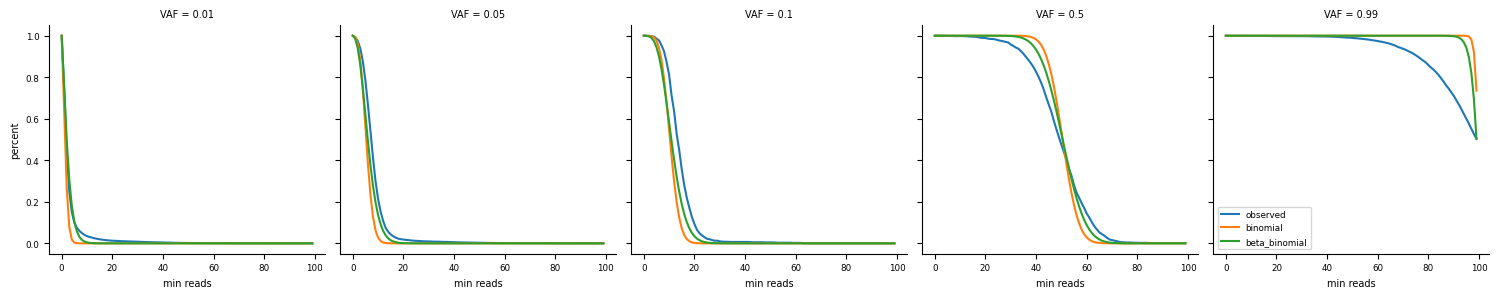

In [14]:
g = sb.FacetGrid(data=view, col='VAF', hue="Measure")
g.map(sb.lineplot, "min reads", "percent")
plt.legend()

In [15]:
from scipy.stats import pearsonr

rows = []
for name, df in predicted.groupby(['VAF']):
    rows.append((name[0], pearsonr(df['observed'], df['binomial']).statistic, 
                pearsonr(df['observed'], df['beta_binomial']).statistic))
corr = pd.DataFrame(rows, columns=['VAF', 'Obs_Bin', 'Obs_BeBin'])

In [16]:
corr

,VAF,Obs_Bin,Obs_BeBin
0,0.01,0.972956,0.996281
1,0.05,0.966297,0.991743
2,0.10,0.966837,0.985704
3,0.50,0.990780,0.996701
4,0.99,0.445151,0.623328


In [17]:
# Building VAF distribution from TR allele data
import truvari
data = pd.read_parquet("/Users/english/code/SMaHT_MIMS/allele_delta/data/hapmix.allele_delta.hifi.WashU.pq")

# All alternate alleles ≥5bp
j = data.set_index(['chrom', 'start', 'end'])
# Condition 1: all non-zero expected_len are > 5
cond1 = j[j['expected_len'] != 0]['expected_len'].abs().gt(5).groupby(['chrom', 'start', 'end']).all()
# Condition 2: at least one non-zero expected_len
cond2 = j['expected_len'].ne(0).groupby(['chrom', 'start', 'end']).any()
# Combine both conditions
keep = cond1 & cond2
# Subset data
data = j.loc[keep[keep].index].reset_index()

data['vafbin'] = pd.cut(data['expected_vaf'], np.linspace(0, 1, 100))

#data['vafbin'] = pd.cut(data['expected_vaf'], bins=[0, 0.01, 0.05, 0.3, 0.7, 1], 
#                        labels=[0.01 / 2, (0.01 + 0.05) / 2, (0.05 + 0.3) / 2, (0.3 + 0.7) / 2, (0.7 + 1) / 2])

subset = data#data[data['expected_len'] != 0].copy()
subset['szbin'] = subset['expected_len'].apply(lambda x: truvari.get_sizebin(x))

cnts = data['vafbin'].value_counts(sort=False)
cnts /= cnts.sum()
# change to 50 for just SVs
sv_cnts = data[data['expected_len'].abs() >= 0]['vafbin'].value_counts(sort=False)
sv_cnts /= sv_cnts.sum()
vafs = [[_.mid, sv_cnts.loc[_]] for _ in sv_cnts.index]


In [21]:
beta_binomial_probability(.01, 100, 1)

0.7487562189054863

In [18]:
def vaf_over_range(vaf_min, vaf_max, vaf_values, coverage, min_reads):
    # Calculate the beta-binomial probabilities for each VAF in the empirical data
    probabilities = []
    weights = []
    for vaf, cnt in vaf_values:
        if vaf_min <= vaf < vaf_max:
            probabilities.append(beta_binomial_probability(vaf, coverage, min_reads))
            weights.append(cnt)
    
    # Compute the weighted average of probabilities
    weighted_prob = np.average(probabilities, weights=weights)
    
    return weighted_prob

In [19]:
import json
print(json.dumps(vafs))

[[0.00505, 0.23280759349129318], [0.01515, 0.05909220667998858], [0.02525, 0.021110476734227803], [0.03535, 0.007964601769911504], [0.045450000000000004, 0.07778332857550671], [0.05555, 0.04232086782757636], [0.06565, 0.024864401941193263], [0.07575, 0.014887239508992293], [0.08585, 0.00889951470168427], [0.09595000000000001, 0.010398230088495575], [0.10600000000000001, 0.008143020268341421], [0.11599999999999999, 0.0070510990579503285], [0.126, 0.005416785612332287], [0.136, 0.004924350556665715], [0.1465, 0.004117898943762489], [0.157, 0.0032686268912360834], [0.16699999999999998, 0.0018270054239223523], [0.177, 0.0], [0.187, 0.0], [0.197, 0.0], [0.20700000000000002, 0.0], [0.217, 0.0], [0.227, 0.0], [0.237, 0.0], [0.2475, 0.0], [0.258, 0.0], [0.268, 0.0], [0.278, 0.0], [0.288, 0.0], [0.298, 0.0], [0.308, 0.0], [0.318, 0.0], [0.328, 0.0], [0.338, 0.0], [0.34850000000000003, 0.0], [0.359, 0.0], [0.369, 0.0], [0.379, 0.0], [0.389, 0.0], [0.399, 0.0], [0.40900000000000003, 0.0], [0.419,

In [20]:
print(beta_binomial_probability(0.01, 100, 0))
print(beta_binomial_probability(0.01, 100, 1))
print(beta_binomial_probability(0.01, 100, 2))

1
0.7487562189054863
0.4962499062477247


In [23]:
mbins = [(0, 1, 'All TR'), 
         (0, 0.01, '<0.1'), 
         (0.01, 0.025, '[0.01, 0.025)'), 
         (0.025, 0.05, '[0.025, 0.05)'), 
         (0.05, 0.30, '[0.05, 0.30)'), 
         (0.30, 1, 'Germline')]

mbins = [(0, 1, 'All TR'), 
         (0, 0.05, '<5%'),
         (0.05, 0.30, '5%-30%'), 
         (0.30, 1, 'Germline')]
                              #(0.30, 0.70, '[0.3, 0.7)'), (0.70, 1, '≥0.7)')]:
b = [0] + [_[1] for _ in mbins[1:]]
l = [_[2] for _ in mbins[1:]]

# expected_vaf for TR, VAF for snp/SV
pd.cut(data['expected_vaf'], bins=b, labels=l).value_counts()

expected_vaf
Germline    65173
<5%         55874
5%-30%      19073
Name: count, dtype: int64

In [24]:
rows = [] 
for lower, upper, vaf_bin in mbins:
    for cov in range(1, 150):
        rows.append([vaf_bin, vaf_over_range(lower, upper, vafs, 98, cov), cov])
theo = pd.DataFrame(rows, columns=['VAF Bin', "recall", "min reads"])


/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1222/2003750193.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  prob += binom_coeff * beta_term


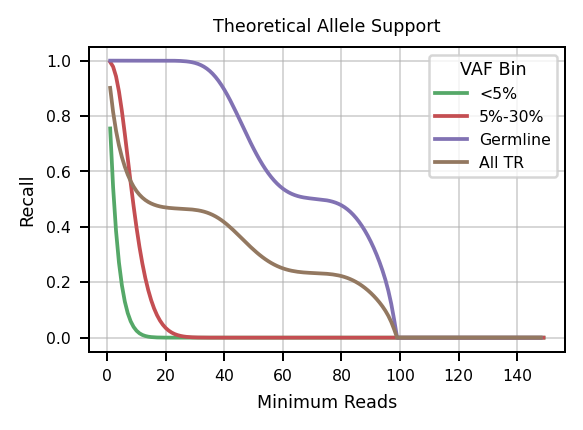

In [25]:
# Theoretical Allele Support CDF

palette = sb.color_palette('deep', n_colors=8) 

def scaled_fontsize(base_size, fig_width, reference_width=6.4, min_size=7):
    """
    Scales the base font size proportionally to figure width,
    but enforces a minimum font size.
    
    base_size: font size for reference_width (in inches)
    fig_width: actual figure width
    """
    scale = fig_width / reference_width
    return max(min_size, base_size * scale)


fig_width = 3.25
font_size = scaled_fontsize(base_size=12, fig_width=fig_width, min_size=7)

plt.rcParams.update({
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size * 0.9,
    "ytick.labelsize": font_size * 0.9,
    "legend.fontsize": font_size * 0.9,
})

fig, ax = plt.subplots(nrows=1, 
                       ncols=1, 
                       #figsize=(5 * len(files), 5), 
                       figsize=(3.25, 2.4), # For hifi.washu
                       squeeze=False,
                       sharex='row',
                       sharey='row',
                       dpi=180,
                      )

p = sb.lineplot(data=theo, 
                x="min reads", 
                y="recall", 
                hue='VAF Bin',
                hue_order=['<5%', '5%-30%', 'Germline', 'All TR'],
                zorder=2, 
                ax = ax[0][0],
               palette=palette[2:-2],
               )
_ = p.set(ylabel="Recall", xlabel="Minimum Reads", 
          #title=f"Allele Coverage {tech} {center}\n(Mean Coverage {mean_cov}x)",
          title=f"Theoretical Allele Support",
         )
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Likelihood of data given observation

In [42]:
import glob
import scipy.special as sp
import numpy as np
import pandas as pd
from scipy.stats import binom

def beta_binomial_pmf(k, n, vaf):
    alpha = n * vaf + 1
    beta = n * (1 - vaf) + 1
    binom_coeff = sp.comb(n, k)
    beta_term = sp.beta(k + alpha, n - k + beta) / sp.beta(alpha, beta)
    return binom_coeff * beta_term
    
    
files = glob.glob("/Users/english/code/SMaHT_MIMS/allele_delta/data/*pq")
rows = []
for fn in files:
    df = pd.read_parquet(fn)
    df = df[df['coverage'] != 0]
    
    # All alternate alleles ≥5bp
    j = df.set_index(['chrom', 'start', 'end'])
    # Condition 1: all non-zero expected_len are > 5
    cond1 = j[j['expected_len'] != 0]['expected_len'].abs().gt(5).groupby(['chrom', 'start', 'end']).all()
    # Condition 2: at least one non-zero expected_len
    cond2 = j['expected_len'].ne(0).groupby(['chrom', 'start', 'end']).any()
    # Combine both conditions
    keep = cond1 & cond2
    # Subset data
    df = j.loc[keep[keep].index].reset_index()
    
    _, _, tech, center, _ = fn.split('/')[-1].split('.')

    log_probs = []

    for _, row in df.iterrows():
        vaf = row["expected_vaf"]
        coverage = int(row["coverage"])
        support = int(row["read_count"])

        prob = beta_binomial_pmf(support, coverage, vaf)
        if prob > 0:
            log_probs.append(np.log(prob))
        else:
            # Assign a large negative value if probability is numerically 0
            log_probs.append(-1e6)

    beta_total_log_likelihood = np.sum(log_probs)
    binom_log_probs = np.log(binom.pmf(df["read_count"], df["coverage"], df["expected_vaf"]))
    n_loci = len(df[['chrom', 'start', 'end']].drop_duplicates())
    n_alleles = len(df)
    rows.append([tech, center,
                 beta_total_log_likelihood, 
                 binom_log_probs.sum(),
                 df['coverage'].mean(), 
                 df['coverage'].std(), 
                 n_loci, 
                 n_alleles])
    
result = pd.DataFrame(rows, columns=["Technology", "Center", "Beta-Binomial Log-Likelihood", 
                                     "Binomial Log-Likelihood", "Mean Coverage", "Coverage STD",
                                     "Num Loci", "Num Alleles"])

In [43]:
result.to_csv("log-likelihood.tsv", sep='\t', index=False)

# Theoretical for 50x, 75x, 100x, 150x, 300x, 500x Supplementary

In [60]:
mbins = [(0, 1, 'All TR'), 
         (0, 0.01, '<0.1'), 
         (0.01, 0.025, '[0.01, 0.025)'), 
         (0.025, 0.05, '[0.025, 0.05)'), 
         (0.05, 0.30, '[0.05, 0.30)'), 
         (0.05, 0.70, '[0.30, 0.70]'), 
         (0.70, 1, '>0.70')]    

b = [0] + [_[1] for _ in mbins[1:]]
l = [_[2] for _ in mbins[1:]]

rows = [] 
for cov_upper in [50, 75, 100, 150, 300, 500]:
    for lower, upper, vaf_bin in mbins:
        for minread in range(1, cov_upper + 10):
            rows.append([vaf_bin, vaf_over_range(lower, upper, vafs, cov_upper, minread), minread, cov_upper])
theo_full = pd.DataFrame(rows, columns=['VAF Bin', "recall", "min reads", "coverage"])

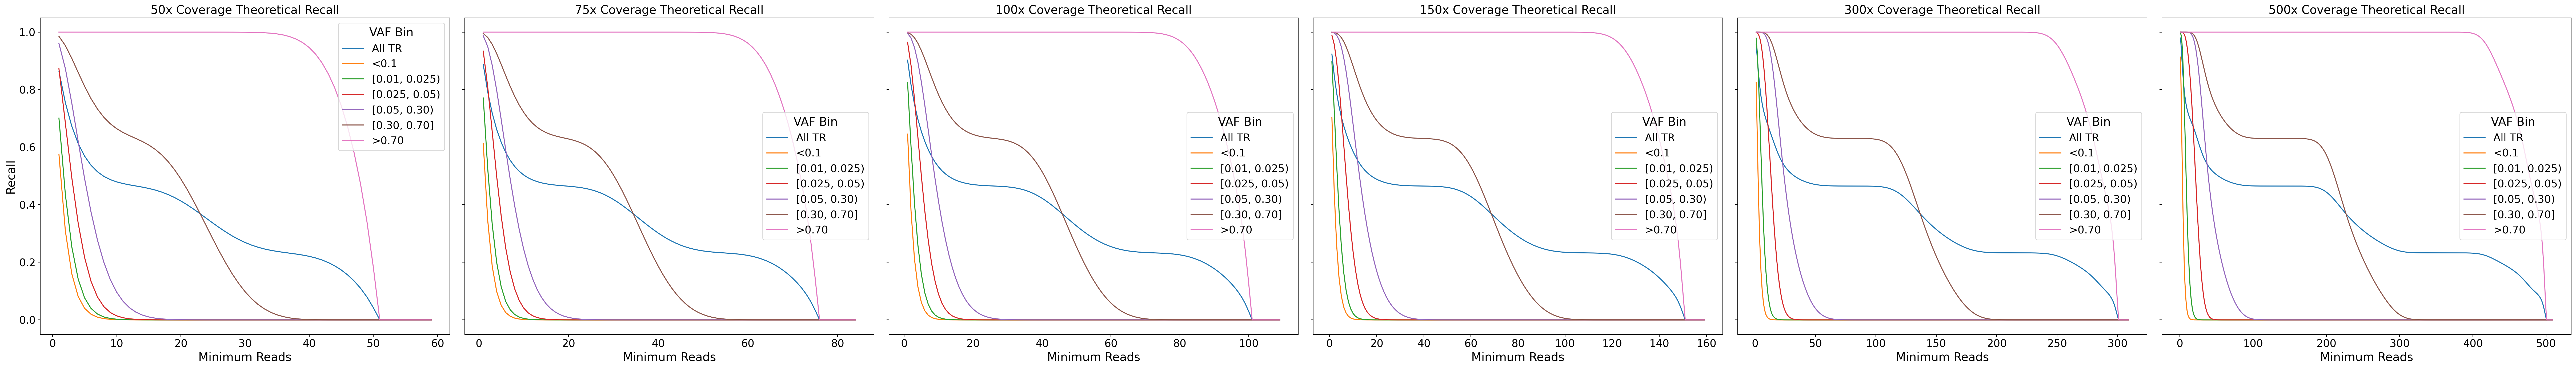

In [78]:
depths = [50, 75, 100, 150, 300, 500]

fig_width = 8# 9 * len(depths)
font_size = scaled_fontsize(base_size=14, fig_width=fig_width, min_size=7)

plt.rcParams.update({
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size * 0.9,
    "ytick.labelsize": font_size * 0.9,
    "legend.fontsize": font_size * 0.9,
})

fig, ax = plt.subplots(nrows=1, 
                       ncols=len(depths), 
                       figsize=(9 * len(depths), fig_width), 
                       squeeze=False,
                       sharex=False,
                       sharey='row',
                       dpi=180,
                      )
for idx, depth in enumerate(depths):
    p = sb.lineplot(data=theo_full[theo_full['coverage'] == depths[idx]],
                x='min reads',
                y='recall', 
                hue='VAF Bin', 
                ax=ax[0][idx])
    p.set(title=f"{depths[idx]}x Coverage Theoretical Recall", ylabel="Recall", xlabel="Minimum Reads")
plt.tight_layout()
plt.show()


In [59]:
vaf_over_range(0.30, 0.70, vafs, 500, 550)

7.568169542916133e-13

In [39]:
theo_full[(theo_full['coverage'] == 600) 
          & (theo_full['VAF Bin'] == '[0.30, 0.70]')
         & (theo_full['min reads'] >= 90)]

,VAF Bin,recall,min reads,coverage
8174,"[0.30, 0.70]",0.652144,90,600
8175,"[0.30, 0.70]",0.650600,91,600
8176,"[0.30, 0.70]",0.649128,92,600
8177,"[0.30, 0.70]",0.647727,93,600
8178,"[0.30, 0.70]",0.646395,94,600
...,...,...,...,...
8689,"[0.30, 0.70]",0.630390,605,600
8690,"[0.30, 0.70]",0.630390,606,600
8691,"[0.30, 0.70]",0.630390,607,600
8692,"[0.30, 0.70]",0.630390,608,600


In [4]:
count.set_index(['svtype', 'szbin', 'TRF'], inplace=True)

In [10]:
count = count.T

In [12]:
total = count.sum(axis=0)

In [19]:
filtered = total < 10

In [24]:
count

svtype      DEL                                                        \
szbin  [50,100)       [100,200)       [200,300)       [300,400)         
TRF       False True      False True      False True      False True    
False       414  1807       248   772       139   190       251   126   
True        674  2616       461  1166       295   266      1252   240   

svtype                  ...       INS                                       \
szbin  [400,600)        ... [600,800)       [800,1k)       [1k,2.5k)         
TRF        False True   ...     False True     False True      False True    
False         96    60  ...        61   341       48   185       236   487   
True         180    96  ...       121   178      107    88       342   225   

svtype                              
szbin  [2.5k,5k)        >=5k        
TRF        False True  False True   
False        173   162   178    82  
True         224    69   150    27  

[2 rows x 40 columns]

In [30]:
cont_obs = count.T[~filtered].T

In [31]:
chi, pval, dof, exp = chi2_contingency(cont_obs)

In [34]:
cont_obs

svtype      DEL                                                        \
szbin  [50,100)       [100,200)       [200,300)       [300,400)         
TRF       False True      False True      False True      False True    
False       414  1807       248   772       139   190       251   126   
True        674  2616       461  1166       295   266      1252   240   

svtype                  ...       INS                                       \
szbin  [400,600)        ... [600,800)       [800,1k)       [1k,2.5k)         
TRF        False True   ...     False True     False True      False True    
False         96    60  ...        61   341       48   185       236   487   
True         180    96  ...       121   178      107    88       342   225   

svtype                              
szbin  [2.5k,5k)        >=5k        
TRF        False True  False True   
False        173   162   178    82  
True         224    69   150    27  

[2 rows x 38 columns]

In [46]:
c_total = cont_obs.sum(axis=0)
r_total = cont_obs.sum(axis=1)
gtotal = c_total.sum()
expected = np.outer(r_total, c_total) / gtotal

1.0

In [45]:
r_total[1] * c_total[0] / gtotal

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1217/3052065876.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_total[1] * c_total[0] / gtotal


597.8740111338998

In [33]:
pd.DataFrame(exp)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,490.125989,1992.48828,319.392763,873.036918,195.509815,205.420451,677.076619,164.876941,124.333431,70.275418,...,81.987987,233.800908,69.824934,122.981981,260.379432,320.744213,178.841928,104.061676,147.75857,49.102696
1,597.874011,2430.51172,389.607237,1064.963082,238.490185,250.579549,825.923381,201.123059,151.666569,85.724582,...,100.012013,285.199092,85.175066,150.018019,317.620568,391.255787,218.158072,126.938324,180.24143,59.897304


```
- Rows = states
- Columns = categories of variables
- Each cell = observed count for that combination
E[i][j] = (R[i] * C[j]) / N
```

In [41]:
cont_obs.sum(axis=1)

False    15375
True     18755
dtype: int64

In [39]:
(414 + 674) / (2)

544.0